In [ ]:
!pip install tensorflow
!pip install opencv-python opencv-python-headless opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 546.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 17.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [01:11<00:00, 165MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [ ]:
train_dir = os.path.join(path, "Train")
test_dir = os.path.join(path, "Test")

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]
num_classes = len(classes)

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

img_width, img_height = 200, 200

def balance_dataset(directory, classes, max_samples_per_class=7140):
    X, y = [], []
    class_to_label = {class_name: i for i, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        image_files = os.listdir(class_dir)[:max_samples_per_class]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))
                image = image / 255.0
                X.append(image)
                y.append(class_to_label[class_name])

    return np.array(X), np.array(y)

X_train, y_train = balance_dataset(train_dir, classes)
X_test, y_test = balance_dataset(test_dir, classes)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=35)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

input_layer = Input(shape=(img_width, img_height, 3))

x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False



<ipython-input-21-ebd3ec121b04>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 200, 200, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,681 (9.24 MB)

 Trainable params: 164,697 (643.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 445s 247ms/step - accuracy: 0.5974 - loss: 1.0232 - val_accuracy: 0.8646 - val_loss: 0.3916
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 429s 240ms/step - accuracy: 0.8322 - loss: 0.4704 - val_accuracy: 0.9273 - val_loss: 0.2239
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 428s 240ms/step - accuracy: 0.8848 - loss: 0.3302 - val_accuracy: 0.9448 - val_loss: 0.1692
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 417s 234ms/step - accuracy: 0.9099 - loss: 0.2626 - val_accuracy: 0.9485 - val_loss: 0.1524
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 425s 238ms/step - accuracy: 0.9228 - loss: 0.2239 - val_accuracy: 0.9518 - val_loss: 0.1409
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 427s 239ms/step - accuracy: 0.9351 - loss: 0.1930 - val_accuracy: 0.9577 - val_loss: 0.1208
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 419s 235ms/step - accuracy: 0.9395 - loss: 0.1759 - val_accuracy: 0.9601 - val_loss: 0.1173
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 421s 236ms/step - ac

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.9817 - loss: 0.0594
Train Accuracy: 96.69%
Test Accuracy: 98.15%


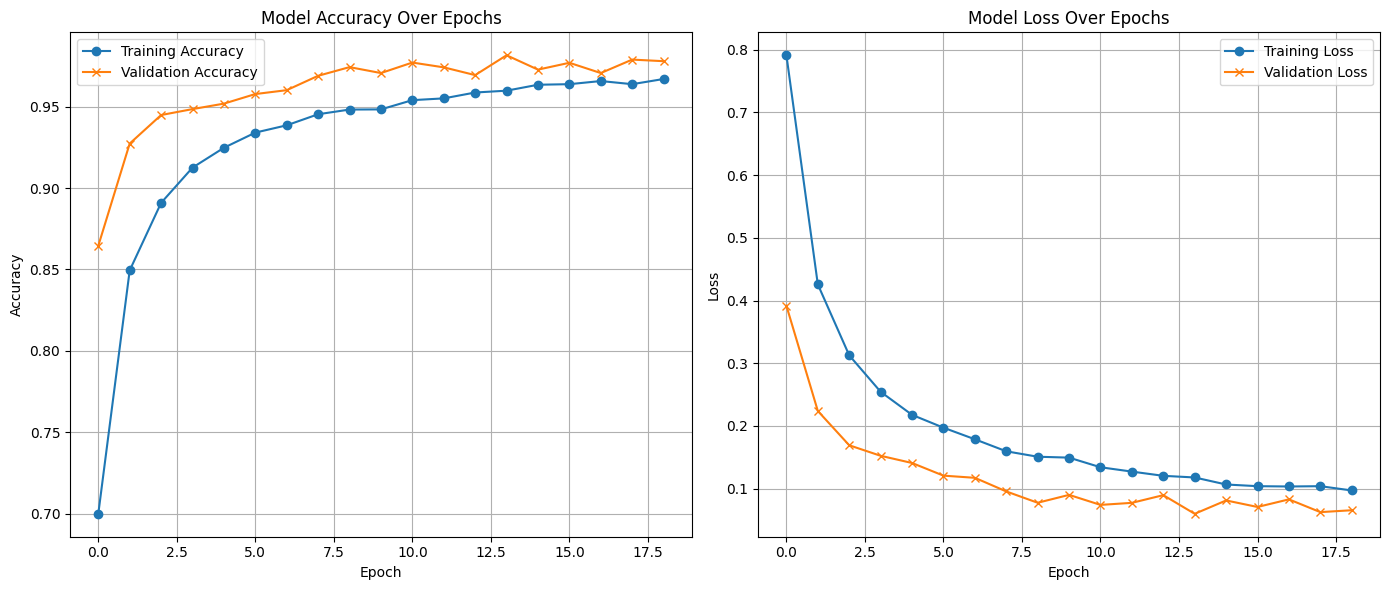

224/224 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step


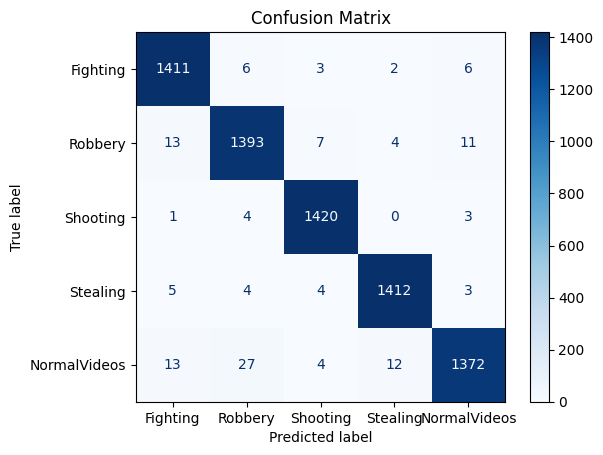

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :10: Robbery
predicted crime is: 10: Robbery


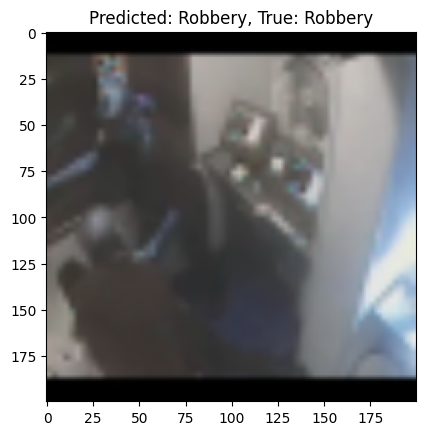

In [ ]:
image_index = 10
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])  # عرض الصورة
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


### reduce DropOut and epochs

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=35)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

input_layer = Input(shape=(img_width, img_height, 3))

x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())


<ipython-input-12-6d57cf0382f3>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,681 (9.24 MB)

 Trainable params: 164,697 (643.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'MobileNet.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
history = model.fit(
    train_generator,
    epochs=28,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/28
816/816 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.6246 - loss: 0.9827
Epoch 1: val_accuracy improved from -inf to 0.87703, saving model to MobileNet.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 375s 453ms/step - accuracy: 0.6247 - loss: 0.9824 - val_accuracy: 0.8770 - val_loss: 0.3738
Epoch 2/28
816/816 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8554 - loss: 0.4112
Epoch 2: val_accuracy improved from 0.87703 to 0.92269, saving model to MobileNet.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 351s 430ms/step - accuracy: 0.8554 - loss: 0.4111 - val_accuracy: 0.9227 - val_loss: 0.2368
Epoch 3/28
816/816 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9057 - loss: 0.2743
Epoch 3: val_accuracy improved from 0.92269 to 0.95308, saving model to MobileNet.keras
816/816 ━━━━━━━━━━━━━━━━━━━━ 352s 431ms/step - accuracy: 0.9057 - loss: 0.2743 - val_accuracy: 0.9531 - val_loss: 0.1467
Epoch 4/28
816/816 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9275 - loss: 0.2134
Epoch 4: val_accuracy im

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 33s 146ms/step - accuracy: 0.9759 - loss: 0.0733
Train Accuracy: 97.26%
Test Accuracy: 97.76%


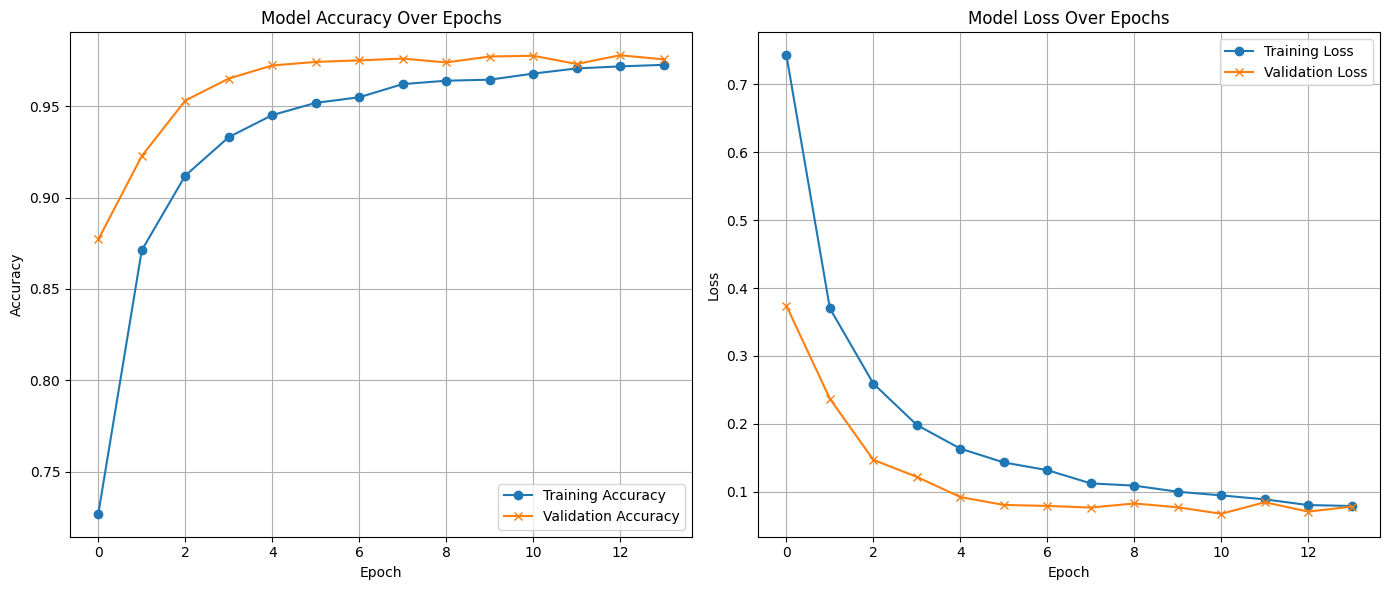

224/224 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step


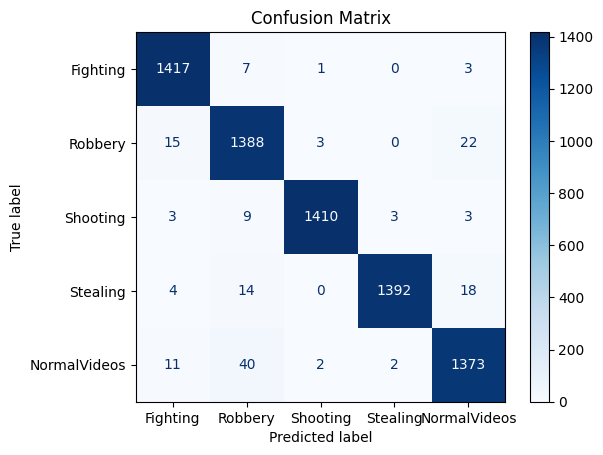

In [15]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :28: Stealing
predicted crime is: 28: Stealing


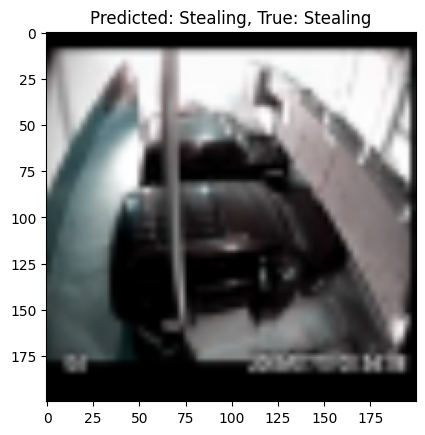

In [19]:
image_index = 28
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])  # عرض الصورة
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [21]:
model.save("mobileNet1.keras")